In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

In [3]:
df1 = pd.read_csv('final1.csv')
print("First few rows of the dataset:")
df1.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,6.9,11.6,4.1
1,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.0,13.0,17.5
2,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.5,13.0,14.0
3,Boulin et al. 2013,Ketzin Claystone,7.0,31.8,15.0,10.4
4,Boulin et al. 2013,Ketzin Claystone,25.0,15.6,15.0,13.0


In [4]:
df2 = pd.read_csv('final2.csv')
print("First few rows of the dataset:")
df2.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,-,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,-,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


In [5]:
df1.shape

(63, 6)

In [6]:
df2.shape

(36, 9)

In [7]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

Synthetic Data Results:
Mean Absolute Error: 2.700717357809727
Mean Squared Error: 12.141983488664078
R-squared: 0.2801842362280087
------------------------------


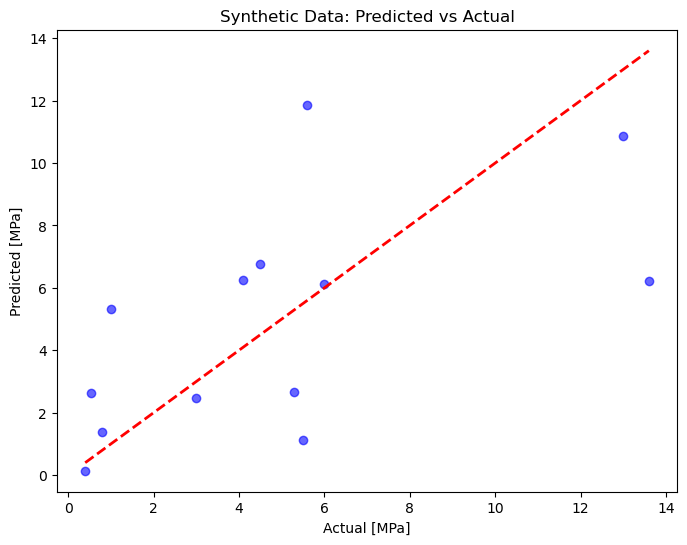

In [28]:
X = df1[['Permeability [nD]', 'Porosity [%]']]
y = df1['Breakthrough pressure [MPa]']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Generate synthetic data using make_regression
X_syn, y_syn = make_regression(n_samples=len(X_train), n_features=X_train.shape[1], noise=0.1, random_state=42)
y_syn = y_syn * np.std(y_train) + np.mean(y_train)  # Scale synthetic target variable to match original distribution

X_train_resampled = np.vstack((X_train, X_syn))
y_train_resampled = np.hstack((y_train, y_syn))

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Synthetic Data Results:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("-" * 30)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual [MPa]')
plt.ylabel('Predicted [MPa]')
plt.title('Synthetic Data: Predicted vs Actual')
plt.show()


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

X = df1[['Permeability [nD]', 'Porosity [%]']]
y = df1['Breakthrough pressure [MPa]']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
y_train_binned = kbins.fit_transform(y_train.values.reshape(-1, 1)).ravel()

n_neighbors = min(5, len(X_train))
smote = SMOTE(sampling_strategy='auto', k_neighbors=n_neighbors, random_state=42)
X_resampled, y_resampled_binned = smote.fit_resample(X_train, y_train_binned)

y_resampled = kbins.inverse_transform(y_resampled_binned.reshape(-1, 1)).ravel()

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("SMOTE Results:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("-" * 30)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual [MPa]')
plt.ylabel('Predicted [MPa]')
plt.title('SMOTE: Predicted vs Actual')
plt.show()

/Users/anshankul/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

Synthetic Data Results:
Mean Absolute Error: 2.479983481764793
Mean Squared Error: 7.769162083637734
R-squared: 0.35130072393867584
------------------------------


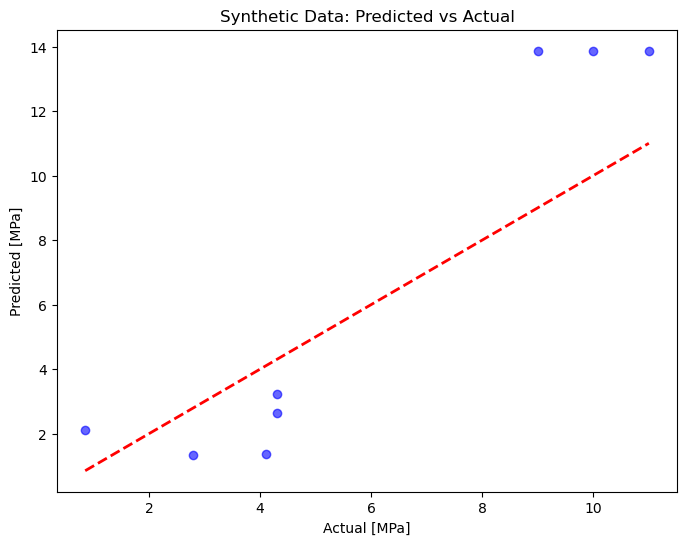

In [44]:
X = df2[['Permeability [nD]', 'Porosity [%]', 'Pore diameter [nm]', 'Clay content [%]']]
y = df2['Breakthrough pressure [MPa]']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Generate synthetic data using make_regression
X_syn, y_syn = make_regression(n_samples=len(X_train), n_features=X_train.shape[1], noise=0.1, random_state=42)
y_syn = y_syn * np.std(y_train) + np.mean(y_train)  # Scale synthetic target variable to match original distribution

X_train_resampled = np.vstack((X_train, X_syn))
y_train_resampled = np.hstack((y_train, y_syn))

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Synthetic Data Results:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("-" * 30)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual [MPa]')
plt.ylabel('Predicted [MPa]')
plt.title('Synthetic Data: Predicted vs Actual')
plt.show()


Cross-Validation Results:
Average Mean Absolute Error: 3.0897580220546472
Average Mean Squared Error: 30.160981842847416
Average R-squared: -0.8211575004531818


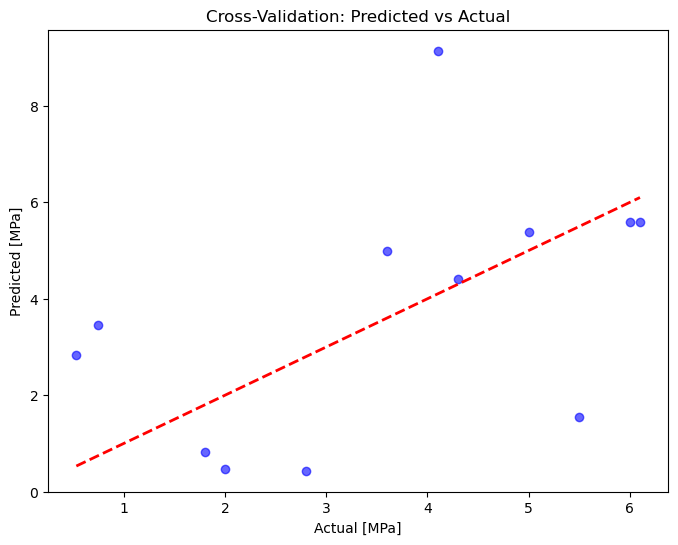

In [52]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

df = df1[['Permeability [nD]', 'Porosity [%]', 'Breakthrough pressure [MPa]']]

df.columns = ['Permeability', 'Porosity', 'BreakthroughPressure']

X = df[['Permeability', 'Porosity']]
y = df['BreakthroughPressure']

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print("Cross-Validation Results:")
print(f"Average Mean Absolute Error: {avg_mae}")
print(f"Average Mean Squared Error: {avg_mse}")
print(f"Average R-squared: {avg_r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual [MPa]')
plt.ylabel('Predicted [MPa]')
plt.title('Cross-Validation: Predicted vs Actual')
plt.show()

In [53]:
df2.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

Cross-Validation Results:
Average Mean Absolute Error: 1.4156465989478997
Average Mean Squared Error: 4.332709245051975
Average R-squared: 0.5249048801306264


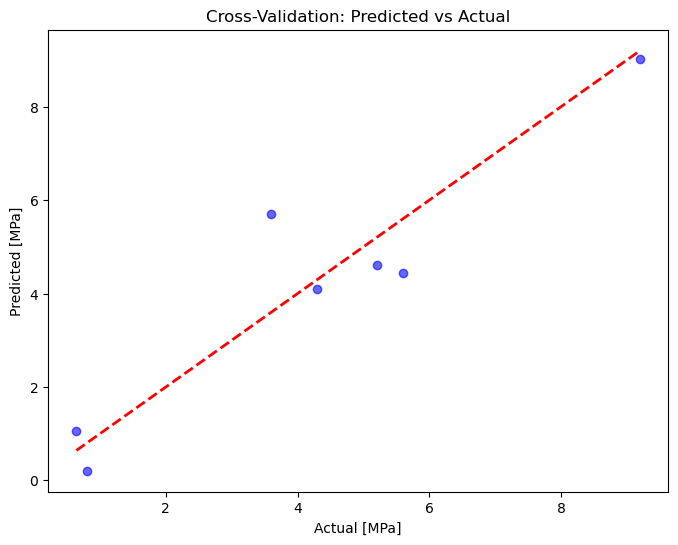

In [56]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

df = df2[['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'Breakthrough pressure [MPa]']]

df.columns = ['Permeability', 'Porosity', 'SSA', 'Pore diameter', 'Clay content', 'BreakthroughPressure']

X = df[['Permeability', 'Porosity', 'Pore diameter', 'Clay content']]
y = df['BreakthroughPressure']

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print("Cross-Validation Results:")
print(f"Average Mean Absolute Error: {avg_mae}")
print(f"Average Mean Squared Error: {avg_mse}")
print(f"Average R-squared: {avg_r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual [MPa]')
plt.ylabel('Predicted [MPa]')
plt.title('Cross-Validation: Predicted vs Actual')
plt.show()